In [15]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

## For the dynamics

In [ ]:
def load_json_files_to_dataframe(directory):
    all_data = []

    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
                row = {
                    'd': data['d'],
                    'n': data['n'],
                    'p': data['p'],
                    'final_train_loss': data['final_train_loss'],
                    'final_test_loss': data['final_test_loss'],
                    'final_train_loss_star': data['final_train_loss_star'], 
                    'final_test_loss_star': data['final_test_loss_star'],
                    'train_losses': data['train_losses'],
                    'test_losses': data['test_losses'],
                    'grad_norms': data['grad_norms'],
                    'train_losses_star': data['train_losses_star'],
                    'test_losses_star': data['test_losses_star'],
                    'train_loss_pseudo': data['train_loss_pseudo'],
                    'test_loss_pseudo': data['test_loss_pseudo'],
                    'target': data['target'],
                    'eps': data['eps'],
                    'eta': data['eta'],
                    'T': data['T'],
                    'C_clip': data['C_clip'],
                    'C_time': data['C_time']
                }
                all_data.append(row)
    
    df = pd.DataFrame(all_data)
    
    return df

In [ ]:
def plot_test_losses(df, n, p, target, eps_values):
    # Filter the DataFrame based on the fixed parameters and d=100
    df_filtered = df[
        (df['n'] == n) & 
        (df['p'] == p) & 
        (df['target'] == target) & 
        (df['eps'].isin(eps_values))
    ]

    # Get unique values of C_clip and C_time and sort them
    unique_C_clip = sorted(df_filtered['C_clip'].unique())
    unique_C_time = sorted(df_filtered['C_time'].unique(), reverse=True)
    
    # Set the seaborn style and define a fixed color palette for eps values
    sns.set(style='darkgrid')
    # viridis_colors = sns.color_palette('viridis', n_colors=20)  # Get colors from viridis palette
    my_colors = [[0.93, 0.82, 0.80],
        [0.66, 0.40, 0.56],
        [0.18, 0.12, 0.24]]
    eps_palette = dict(zip(sorted(eps_values), my_colors))  # Map eps values to viridis colors


    # Create subplots for test losses
    fig, axs = plt.subplots(len(unique_C_time), len(unique_C_clip), figsize=(4 * len(unique_C_clip), 2.8 * len(unique_C_time)), sharey=True)

    for i, C_time in enumerate(unique_C_time):
        for j, C_clip in enumerate(unique_C_clip):
            if i == 1 and j == 1:
                subset = df_filtered[(df_filtered['C_clip'] == C_clip) & (df_filtered['C_time'] == C_time)]
                mean_test_loss_star = subset['test_loss_pseudo'].mean()
                std_test_loss_star = subset['test_loss_pseudo'].std()
    
    for i, C_time in enumerate(unique_C_time):
        for j, C_clip in enumerate(unique_C_clip):
            ax = axs[i, j] if len(unique_C_time) > 1 else axs[j]
            subset = df_filtered[(df_filtered['C_clip'] == C_clip) & (df_filtered['C_time'] == C_time)]
            if not subset.empty:
                for eps in eps_values:
                    subset_eps = subset[subset['eps'] == eps]
                    if not subset_eps.empty:
                        subset_expanded = pd.DataFrame()
                        for index, row in subset_eps.iterrows():
                            epochs = range(len(row['test_losses']))
                            temp_df = pd.DataFrame({
                                'epoch': epochs,
                                'test_loss': row['test_losses']
                            })
                            subset_expanded = pd.concat([subset_expanded, temp_df], ignore_index=True)
                        
                        # Plot the line manually with a fixed color from the palette
                        sns.lineplot(data=subset_expanded, x='epoch', y='test_loss', ax=ax, color=eps_palette[eps], label=rf'$\varepsilon = {eps}$')
            
            p = 'p'
            title_text = ax.set_title(rf'$C_{{\text{{clip}}}} \, / \sqrt{{p}} = {C_clip}  \quad  C_{{\text{{time}}}} = {C_time}$', fontsize=12, loc='left', pad=-20)
            title_text.set_position((0.38, 0.02))

            if i == 2:
                ax.set_xlabel('Epoch')
            else:
                ax.set_xlabel('')

            ax.set_ylabel('Test loss')
            ax.set_ylim(0.34, 1.21)  # Set y-axis limits

            # Only add the legend to the first subplot (top left)
            if i == 0 and j == 0:
                ax.legend(loc='upper left')
            else:
                ax.get_legend().remove()  # Remove the legend from other subplots

    plt.tight_layout()

    # Save the figure as PDF
    fig.savefig('RF_original_no_blue.pdf', format='pdf')
    
    plt.show()

In [ ]:
directory = './synthetic/03_09_original'

# Load data into DataFrame
df = load_json_files_to_dataframe(directory)

In [ ]:
def create_df_light(df):
    # Function to reduce the list size by picking one value every 100 entries
    def reduce_list(lst):
        return lst[::50]  # Take one value every 100

    # Apply the reduction to the relevant columns
    df_light = df.copy()
    df_light['train_losses'] = df_light['train_losses'].apply(reduce_list)
    df_light['test_losses'] = df_light['test_losses'].apply(reduce_list)
    df_light['train_losses_star'] = df_light['train_losses_star'].apply(reduce_list)
    df_light['test_losses_star'] = df_light['test_losses_star'].apply(reduce_list)
    
    return df_light


df_light = create_df_light(df)

In [ ]:
plot_test_losses(df, n=2000, p=40000, target='sign', eps_values=[1, 2, 4])

## For the grid

In [ ]:
def load_parameters_to_dataframe(directory):
    all_data = []
    
    for filename in os.listdir(directory):
        if filename.startswith("parameters_") and filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as f:
                for line in f:
                    values = line.strip().split('\t')
                    data = {
                        'd': int(values[0]),
                        'n': int(values[1]),
                        'p': int(values[2]),
                        # 'final_train_loss': float(values[3]),
                        'final_test_loss': float(values[3]),
                        # 'train_loss_star': float(values[5]),
                        # 'test_loss_star': float(values[6]),
                        'target': values[4],
                        'eps': float(values[5]),
                        'CT': float(values[6]),
                        'C': float(values[7])
                    }
                    all_data.append(data)
    
    df = pd.DataFrame(all_data)
    return df

In [ ]:
directory = './synthetic/30_08_grid'

df = load_parameters_to_dataframe(directory)

In [ ]:
def plot_heatmap(df, d, n, p, epsilons, value_cap=None):
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(12, 4.2), gridspec_kw={'width_ratios': [1, 1, 1]}, constrained_layout=True)

    # Store the minimum and maximum values across all epsilon heatmaps for consistent color scaling
    vmin, vmax = np.inf, -np.inf
    
    # First pass: Calculate the global min and max for color scaling
    for eps in epsilons:
        df_filtered = df[
            (df['d'] == d) & 
            (df['n'] == n) & 
            (df['p'] == p) & 
            (df['eps'] == eps)
        ]

        df_grouped = df_filtered.groupby(['C', 'CT']).agg({
            'final_test_loss': 'mean'
        }).reset_index()

        # Apply the cap to limit excessively high values if specified
        if value_cap:
            df_grouped['final_test_loss'] = df_grouped['final_test_loss'].apply(lambda x: min(x, value_cap))

        # Pivot the DataFrame to get CT and C on the axes
        heatmap_data = df_grouped.pivot(index='CT', columns='C', values='final_test_loss')

        if heatmap_data.empty:
            raise ValueError(f"No data available to plot for the given parameters: d={d}, n={n}, p={p}, eps={eps}")

        # Update global min and max
        vmin = min(vmin, heatmap_data.min().min())
        vmax = max(vmax, heatmap_data.max().max())
    
    # Second pass: Plot each heatmap with consistent color scaling
    for ax, eps in zip(axes, epsilons):
        df_filtered = df[
            (df['d'] == d) & 
            (df['n'] == n) & 
            (df['p'] == p) & 
            (df['eps'] == eps)
        ]

        df_grouped = df_filtered.groupby(['C', 'CT']).agg({
            'final_test_loss': 'mean'
        }).reset_index()

        # Apply the cap to limit excessively high values if specified
        if value_cap:
            df_grouped['final_test_loss'] = df_grouped['final_test_loss'].apply(lambda x: min(x, value_cap))

        heatmap_data = df_grouped.pivot(index='CT', columns='C', values='final_test_loss')

        # Plot the heatmap without the color bar for each subplot, except for the last one (eps=4)
        if eps != 4:
            sns.heatmap(heatmap_data, ax=ax, annot=False, cmap="viridis", vmin=vmin, vmax=vmax, cbar=False)
        else:
            sns.heatmap(heatmap_data, ax=ax, annot=False, cmap="viridis", vmin=vmin, vmax=vmax)

        ax.set_title(rf'$\epsilon = {eps}$', fontsize=14)  # LaTeX formatted title
        ax.set_xlabel(r'$C_{\text{clip}} \,/ \sqrt{p}$', fontsize=12)  # LaTeX formatted x-axis

        # Customize tick labels for both axes
        x_ticks = np.arange(0, len(heatmap_data.columns), step=3)  # Set x-ticks every 3rd value
        y_ticks = np.arange(0, len(heatmap_data.index), step=3)    # Set y-ticks every 3rd value
        
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        
        # Use two decimal digits for values smaller than 1, and integer otherwise
        ax.set_xticklabels([f'{heatmap_data.columns[i]:.2f}' if heatmap_data.columns[i] < 1 else f'{int(heatmap_data.columns[i])}' for i in x_ticks])
        ax.set_yticklabels([f'{heatmap_data.index[i]:.2f}' if heatmap_data.index[i] < 1 else f'{int(heatmap_data.index[i])}' for i in y_ticks])
        
        # Remove y-axis label and ticks from the second and third subplots
        if ax != axes[0]:
            ax.set_ylabel('')
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(r'$C_{\text{time}}$', fontsize=12)  # LaTeX formatted y-axis

        ax.plot([0, len(heatmap_data.columns)], [len(heatmap_data.index), 0], 'r--', linewidth=2)
        ax.text(13, 1, r'$T \propto C_{clip}^{-1}$', color='red', fontsize=10)
        
        ax.invert_yaxis()

    # Modify the color bar for the last plot (eps=4)
    cbar = axes[-1].collections[0].colorbar
    ticks = cbar.get_ticks()

    # Modify the highest tick to show "> value_cap"
    ticks = np.append(ticks[:-1], value_cap)  # Retain previous ticks but modify the last one
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{tick:.1f}" if tick < value_cap else f"> {value_cap}" for tick in ticks])

    # Add vertical label to the colorbar
    cbar.set_label('Test loss', rotation=270, labelpad=15, fontsize=12)

    # Save the plot
    fig.savefig('RF_grid_plot.pdf', format='pdf')

    plt.show()

In [ ]:
plot_heatmap(df, d=100, n=2000, p=40000, epsilons=[1, 2, 4], value_cap=1.2)

## For the time

In [6]:
directories = ['./synthetic/15_09_scaling_time_JAX_new_small_eta']

In [7]:
def load_json_files_to_dataframe(directories):
    all_data = []

    # Loop through each directory in the list
    for directory in directories:
        for filename in os.listdir(directory):
            if filename.endswith(".json"):
                filepath = os.path.join(directory, filename)
                with open(filepath, 'r') as file:
                    data = json.load(file)
                    
                    # Extract common data
                    row = {
                        'd': data['d'],
                        'n': data['n'],
                        'p': data['p'],
                        'final_test_loss': data['final_test_loss'],
                        'target': data['target'],
                        'eps': data['eps'],
                        'eta': data['eta'],
                        'T': data['T'],
                        'C_clip': data['C_clip'],
                        'C_time': data['C_time']
                    }
                    all_data.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(all_data)
    
    return df

df_private = load_json_files_to_dataframe(directories)
df_private

,d,n,p,final_test_loss,target,eps,eta,T,C_clip,C_time
0,100,2000,3162,0.563639,sign,4,0.00003,16707,0.5,15.848933
1,100,2000,5011,0.438703,sign,4,0.00003,3293,0.5,4.951501
2,100,2000,1995,0.446705,sign,4,0.00003,12798,0.5,7.659679
3,100,2000,19952,0.651739,sign,4,0.00003,193,0.5,1.156533
4,100,2000,316,0.583415,sign,4,0.00003,18872,0.5,1.789088
...,...,...,...,...,...,...,...,...,...,...
3995,100,2000,199526,0.487091,sign,4,0.00003,228,0.5,13.703839
3996,100,2000,19952,0.536660,sign,4,0.00003,345,0.5,2.069138
3997,100,2000,50,0.800049,sign,4,0.00003,66666,0.5,1.000000
3998,100,2000,125892,0.452018,sign,4,0.00003,113,0.5,4.281333


In [8]:
df_private = df_private[df_private['p'] >= 50].copy()
df_private = df_private[df_private['T'] > 0].copy()

In [9]:
stats_df = df_private.groupby(['p', 'T'])['final_test_loss'].agg(['mean', 'std']).reset_index()
best_T_per_p = stats_df.loc[stats_df.groupby('p')['mean'].idxmin()]
df_private_best = pd.merge(df_private, best_T_per_p[['p', 'T']], on=['p', 'T'])
df_private_best

,d,n,p,final_test_loss,target,eps,eta,T,C_clip,C_time
0,100,2000,5011,0.438703,sign,4,0.00003,3293,0.5,4.951501
1,100,2000,125,0.565214,sign,4,0.00003,204258,0.5,7.659679
2,100,2000,79,0.578175,sign,4,0.00003,241627,0.5,5.726573
3,100,2000,199526,0.412297,sign,4,0.00003,82,0.5,4.951501
4,100,2000,1258,0.447720,sign,4,0.00003,13120,0.5,4.951501
...,...,...,...,...,...,...,...,...,...,...
185,100,2000,3162,0.434445,sign,4,0.00003,6036,0.5,5.726573
186,100,2000,501,0.479101,sign,4,0.00003,44065,0.5,6.622969
187,100,2000,5011,0.439142,sign,4,0.00003,3293,0.5,4.951501
188,100,2000,31622,0.429075,sign,4,0.00003,521,0.5,4.951501


In [10]:
def load_and_plot_json_data(directories):
    data = []
    for folder_path in directories:
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.json'):
                file_path = os.path.join(folder_path, file_name)
                with open(file_path, 'r') as file:
                    json_data = json.load(file)
                    data.append({
                        'p': json_data['p'],
                        'final_test_loss': json_data['test_loss_pseudo']
                    })

    df = pd.DataFrame(data)
    return df

directories = ['./synthetic/15_09_original']
df_star = load_and_plot_json_data(directories)

df_star = df_star[df_star['p'] >= 50].copy()
df_star

,p,final_test_loss
0,125892,0.369955
1,7943,0.538555
2,50,0.801768
3,5011,0.637168
4,1995,150.753340
...,...,...
192,199526,0.378640
193,50118,0.378133
194,79,0.657523
195,125,0.466323


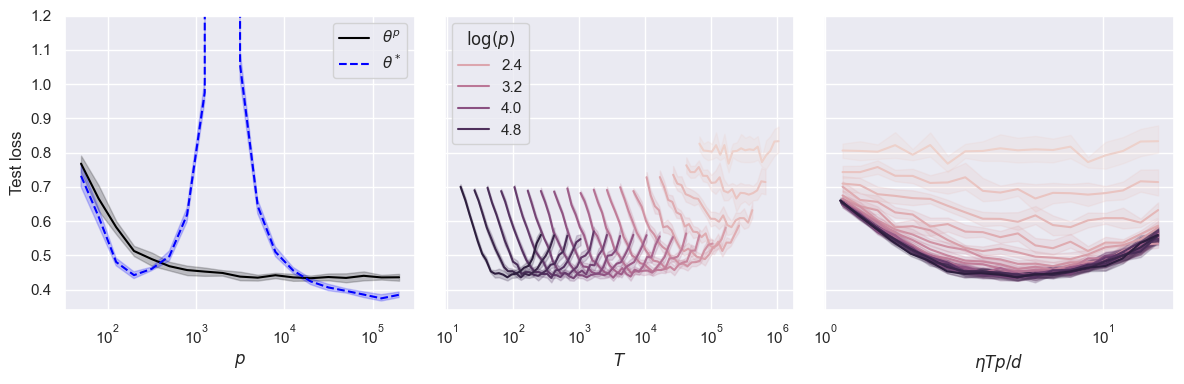

In [11]:
def integrated_plotting_function(df_private, df_private_best, df_star):
    sns.set_theme(style="darkgrid")
    
    df_private_best['source'] = r'$\theta^p$'  # Best test loss
    df_star['source'] = r'$\theta^*$'  # Pseudo test loss
    combined_df = pd.concat([df_private_best, df_star], ignore_index=True)
    combined_df.sort_values(by='p', inplace=True)
    
    # Set up the figure with three subplots
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    # First subplot for combined data
    sns.lineplot(data=combined_df[combined_df['source'] == r'$\theta^p$'], x='p', y='final_test_loss', ax=ax[0], linestyle='-', color='black', label=r'$\theta^p$')
    sns.lineplot(data=combined_df[combined_df['source'] == r'$\theta^*$'], x='p', y='final_test_loss', ax=ax[0], linestyle='--', color='blue', label=r'$\theta^*$')
    ax[0].set_xscale('log')
    ax[0].set_ylim(0.34, 1.2)
    ax[0].set_xlabel(r'$p$', fontsize=12)
    ax[0].set_ylabel('Test loss', fontsize=12)
    ax[0].get_legend()

    # Second subplot for random final test loss
    df_private[r'$\log(p)$'] = np.log10(df_private['p'])
    sns.lineplot(data=df_private, x='T', y='final_test_loss', hue=r'$\log(p)$', ax=ax[1])
    ax[1].set_xscale('log')
    ax[1].set_ylim(0.34, 1.2)
    ax[1].set_xlabel(r'$T$', fontsize=12)
    ax[1].set_ylabel('')
    ax[1].set_yticklabels([])

    # Third subplot for test loss vs. T*p
    df_private['T_p'] = df_private['T'] * df_private['p'] * df_private['eta'] / df_private['d']
    df_private = df_private[df_private['T_p'] >= 1].copy()
    sns.lineplot(data=df_private, x='T_p', y='final_test_loss', hue=r'$\log(p)$', ax=ax[2])
    ax[2].set_xscale('log')
    ax[2].set_ylim(0.34, 1.2)
    ax[2].set_xlabel(r'$\eta T p / d$', fontsize=12)
    ax[2].set_ylabel('')
    ax[2].set_yticklabels([])
    ax[2].get_legend().remove()

    plt.tight_layout()
    plt.show()

    fig.savefig('RF_first_plot.pdf', format='pdf')
    
integrated_plotting_function(df_private, df_private_best, df_star)

## For the paper

In [12]:
def load_parameters_to_dataframe(directory):
    all_data = []
    
    for filename in os.listdir(directory):
        if filename.startswith("parameters_") and filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as f:
                for line in f:
                    values = line.strip().split('\t')
                    data = {
                        'd': int(values[0]),
                        'n': int(values[1]),
                        'p': int(values[2]),
                        # 'final_train_loss': float(values[3]),
                        'final_test_loss': float(values[3]),
                        # 'train_loss_star': float(values[5]),
                        # 'test_loss_star': float(values[6]),
                        'target': values[4],
                        'eps': float(values[5]),
                        'CT': float(values[6]),
                        'C': float(values[7])
                    }
                    all_data.append(data)
    
    df = pd.DataFrame(all_data)
    return df

directory = './synthetic/30_08_grid'
df_grid = load_parameters_to_dataframe(directory)

In [22]:
def plot_RF(df_grid, df_private, df_private_best, df_star):
    # Create a figure with 3 subplots
    
    fig, axes = plt.subplots(1, 4, figsize=(13, 3.5), gridspec_kw={'width_ratios': [1.2, 0.9, 0.7, 1]}, constrained_layout=True)
    sns.set_theme(style="darkgrid")
    axes[0].yaxis.set_major_locator(MaxNLocator(nbins=8))
    axes[1].yaxis.set_major_locator(MaxNLocator(nbins=6))
    axes[2].yaxis.set_major_locator(MaxNLocator(nbins=6))
    
    df_private_best['source'] = r'$\theta^p$'  # Best test loss
    df_star['source'] = r'$\theta^*$'  # Pseudo test loss
    combined_df = pd.concat([df_private_best, df_star], ignore_index=True)
    combined_df.sort_values(by='p', inplace=True)

    # for the grid
    vmin, vmax = np.inf, -np.inf
    d=100
    n=2000
    p=40000
    eps=4
    value_cap=1.6
    df_filtered = df_grid[
        (df_grid['d'] == d) & 
        (df_grid['n'] == n) & 
        (df_grid['p'] == p) & 
        (df_grid['eps'] == eps)
    ]

    df_grouped = df_filtered.groupby(['C', 'CT']).agg({
        'final_test_loss': 'mean'
    }).reset_index()

    if value_cap:
        df_grouped['final_test_loss'] = df_grouped['final_test_loss'].apply(lambda x: min(x, value_cap))

    heatmap_data = df_grouped.pivot(index='CT', columns='C', values='final_test_loss')

    vmin = min(vmin, heatmap_data.min().min())
    vmax = max(vmax, heatmap_data.max().max())

    ax = axes

    sns.lineplot(data=combined_df[combined_df['source'] == r'$\theta^p$'], x='p', y='final_test_loss', ax=ax[0], linestyle='-', color='black', label=r'$\theta^p$')
    sns.lineplot(data=combined_df[combined_df['source'] == r'$\theta^*$'], x='p', y='final_test_loss', ax=ax[0], linestyle='--', color='blue', label=r'$\theta^*$')
    ax[0].set_xscale('log')
    ax[0].set_ylim(0.34, 1.6)
    ax[0].set_xlabel(r'$p$', fontsize=12)
    ax[0].set_ylabel('Test loss', fontsize=12)
    ax[0].get_legend()

    # Second subplot for random final test loss
    df_private[r'$\log(p)$'] = np.log10(df_private['p'])
    sns.lineplot(data=df_private, x='T', y='final_test_loss', hue=r'$\log(p)$', ax=ax[1])
    ax[1].set_xscale('log')
    ax[1].set_ylim(0.4, 1)
    ax[1].set_xlabel(r'$T$', fontsize=12)
    ax[1].set_ylabel('')
    ax[1].legend(title=r'$\log p$')

    # Third subplot for test loss vs. T*p
    df_private['T_p'] = df_private['T'] * df_private['p'] * df_private['eta'] / df_private['d']
    df_private = df_private[df_private['T_p'] >= 1].copy()
    sns.lineplot(data=df_private, x='T_p', y='final_test_loss', hue=r'$\log(p)$', ax=ax[2])
    ax[2].set_xscale('log')
    ax[2].set_ylim(0.4, 1)
    ax[2].set_xlabel(r'$\eta T p / d$', fontsize=12)
    ax[2].set_ylabel('')
    ax[2].set_yticklabels([])
    ax[2].get_legend().remove()



    i = 3
    sns.heatmap(heatmap_data, ax=axes[i], annot=False, cmap="viridis_r", vmin=vmin, vmax=vmax, cbar=True)
    # axes[i].set_title(rf'$\epsilon = {eps}$', fontsize=14)  # LaTeX formatted title
    axes[i].set_xlabel(r'$C_{\text{clip}} \,/ \sqrt{p}$', fontsize=12)  # LaTeX formatted x-axis
    axes[i].set_ylabel(r'$\eta T p / d$', fontsize=12)  # LaTeX formatted y-axis

    x_ticks = np.arange(0, len(heatmap_data.columns), step=3)  # Set x-ticks every 3rd value
    y_ticks = np.arange(0, len(heatmap_data.index), step=3)    # Set y-ticks every 3rd value

    axes[i].set_xticks(x_ticks)
    axes[i].set_yticks(y_ticks)

    axes[i].set_xticklabels([f'{heatmap_data.columns[i]:.2f}' if heatmap_data.columns[i] < 1 else f'{int(heatmap_data.columns[i])}' for i in x_ticks])
    axes[i].set_yticklabels([f'{heatmap_data.index[i]:.2f}' if heatmap_data.index[i] < 1 else f'{int(heatmap_data.index[i])}' for i in y_ticks])

    # axes[i].plot([0, len(heatmap_data.columns)], [len(heatmap_data.index), 0], 'r--', linewidth=2)
    # axes[i].text(12, 1, r'$T \propto C_{clip}^{-1}$', color='red', fontsize=10)
    
    axes[i].invert_yaxis()
    cbar = axes[i].collections[0].colorbar
    ticks = cbar.get_ticks()

    ticks = np.append(ticks[:-1], value_cap)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{tick:.1f}" if tick < value_cap else f"> {value_cap}" for tick in ticks])

    cbar.set_label('Test loss', rotation=270, labelpad=15, fontsize=12)
    
    # fig.tight_layout()
    fig.savefig('RF_complete.pdf', format='pdf')


    plt.show()

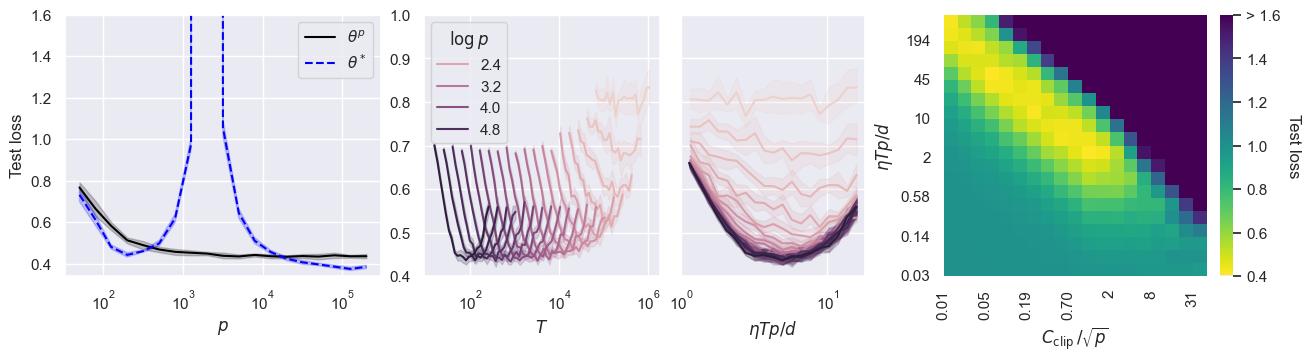

In [23]:
plot_RF(df_grid, df_private, df_private_best, df_star)